<a href="https://colab.research.google.com/github/hohaithuy/Compare-AlexNet-VGG16-and-SIFT-on-Flowers-Dataset/blob/main/SIFTt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIFT
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YoniChechik/AI_is_Math/blob/master/c_08_features/sift.ipynb)



In [ ]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
path = '/content/gdrive/MyDrive/flowers/'
files = os.listdir(path)
print("Flowers dataset:")
for i in files:
  print(f"- {i} : {len(os.listdir(path + i))}")


Flowers dataset:
- daisy : 764
- dandelion : 1052
- rose : 784
- sunflower : 733
- tulip : 984
- lotusflower : 604
- hydrangea : 669
- Gerbera : 600
- Lily : 600


SIFT code is adapted from:
https://towardsdatascience.com/image-stitching-using-opencv-817779c86a83


In [ ]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2
figsize = (10, 10)


In [ ]:
import os

path = '/content/gdrive/MyDrive/flowers/'
def readData(path):
  X = [] #chứa image
  y = [] #chứa label
  label = 0

  classes = os.listdir(path)

  for folder in classes:
    files = sorted(os.listdir(path + folder))
    for i in files[:300]:
      img = cv2.imread(path + folder + '/' + i)
      gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

      # sift = cv2.SIFT_create()
      # kp, des = sift.detectAndCompute(gray,None)

      X.append(img)
      y.append(label)
      return X, y
    label += 1
  return X, y

In [ ]:
import cv2
import os
import glob

def label_image(path_to_data):

  list_label = os.listdir(path_to_data)

  label2id = {}
  for id_, value in enumerate(list_label):
    label2id[value] = id_

  data_train = []
  data_label = []
  for label in list_label:
    print(f"Processing data {label} . . .")
    
    count  = 0
    for img in glob.glob(path_to_data+"/" + label + '/*'):
      if count == 300: break
      image = cv2.imread(img)
      label_image = label2id[label]

      data_train.append(image)
      data_label.append(label_image)
      count += 1
    print("Done!")
  return data_train, data_label, label2id

In [ ]:
import cv2
from sklearn.cluster import KMeans
import pickle
from scipy.spatial.distance import cdist
import os
import numpy as np


def extract_sift_features(list_image):

    image_descriptors = []
    sift = cv2.SIFT_create()#cv2.xfeatures2d.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def kmean_bow(all_descriptors, num_cluster):
    bow_dict = []

    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    if not os.path.isfile('bow_dictionary.pkl'):
        pickle.dump(bow_dict, open('bow_dictionary.pkl', 'wb'))

    return bow_dict

def create_feature_bow(image_descriptors, BoW, num_cluster):

    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)

            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1
        X_features.append(features)

    return X_features

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn
import pickle
import argparse
import os

# arg = argparse.ArgumentParser()
# arg.add_argument("-dt", "--inputdata", required = True, help = "path to data training")
# args = vars(arg.parse_args())

path = '/content/gdrive/MyDrive/flowers'
print(path)
data_train, label, label2id = label_image(path)

image_desctiptors = extract_sift_features(data_train)

all_descriptors = []
for descriptor in image_desctiptors:
    if descriptor is not None:
        for des in descriptor:
            all_descriptors.append(des)

num_cluster = 10
BoW = kmean_bow(all_descriptors, num_cluster)

X_features = create_feature_bow(image_desctiptors, BoW, num_cluster)

/content/gdrive/MyDrive/flowers
Processing data daisy . . .
Done!
Processing data dandelion . . .
Done!
Processing data rose . . .
Done!
Processing data sunflower . . .
Done!
Processing data tulip . . .
Done!
Processing data lotusflower . . .
Done!
Processing data hydrangea . . .
Done!
Processing data Gerbera . . .
Done!
Processing data Lily . . .
Done!


KeyboardInterrupt: ignored

#Test

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

In [ ]:
def Experiment(X, y, model_used, classes):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  clf = model_used
  clf.fit(X_train, y_train)

  y_predict = clf.predict(X_test)

  from sklearn.metrics import classification_report, confusion_matrix
  print(classification_report(y_test, y_predict, target_names=classes))
  print( confusion_matrix(y_test, y_predict))
  from sklearn.metrics import accuracy_score
  print(accuracy_score(y_test,y_predict))


  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(confusion_matrix(y_test, y_predict), classes=classes,
                        title='Confusion matrix, without normalization')
  # Plot normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(confusion_matrix(y_test, y_predict), classes=classes, normalize=True,
                        title='Normalized confusion matrix')
  plt.show()


####Running

In [ ]:
classes = list(label2id)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       daisy       0.39      0.48      0.43        91
   dandelion       0.65      0.53      0.58       112
        rose       0.36      0.32      0.34        91
   sunflower       0.50      0.54      0.52        93
       tulip       0.39      0.29      0.33       115
 lotusflower       0.48      0.64      0.55        92

    accuracy                           0.46       594
   macro avg       0.46      0.47      0.46       594
weighted avg       0.46      0.46      0.46       594

[[44  8  8 12  7 12]
 [25 59  9  9  7  3]
 [ 9  8 29  7 21 17]
 [11  6  5 50 13  8]
 [16  7 17 17 33 25]
 [ 8  3 12  6  4 59]]
0.4612794612794613


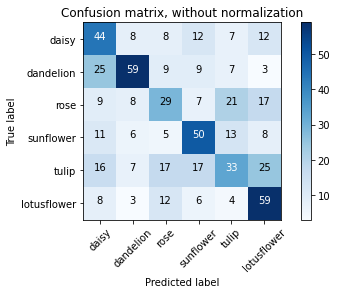

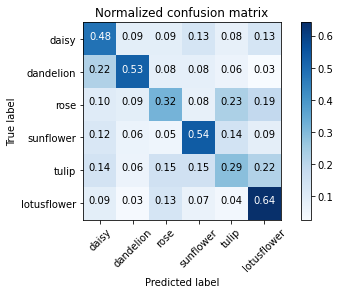

In [ ]:
#Logistic Regression
Experiment(X_features, label, LogisticRegression(), classes)

              precision    recall  f1-score   support

       daisy       0.43      0.52      0.47        91
   dandelion       0.65      0.59      0.62       112
        rose       0.35      0.35      0.35        91
   sunflower       0.60      0.62      0.61        93
       tulip       0.45      0.36      0.40       115
 lotusflower       0.52      0.60      0.56        92

    accuracy                           0.50       594
   macro avg       0.50      0.51      0.50       594
weighted avg       0.50      0.50      0.50       594

[[47 11  5  6  9 13]
 [17 66  7  8 11  3]
 [10  9 32  9 20 11]
 [12  6  6 58  5  6]
 [12  6 29 10 41 17]
 [11  4 12  5  5 55]]
0.5033670033670034


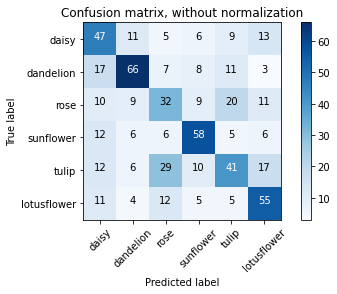

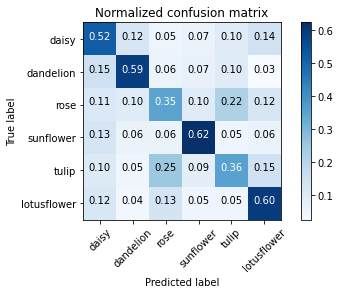

In [ ]:
#SVM
Experiment(X_features, label, SVC(C = 30), classes)

              precision    recall  f1-score   support

       daisy       0.38      0.05      0.10        91
   dandelion       0.44      0.06      0.11       112
        rose       0.16      0.79      0.26        91
   sunflower       0.46      0.29      0.36        93
       tulip       0.41      0.14      0.21       115
 lotusflower       0.44      0.04      0.08        92

    accuracy                           0.22       594
   macro avg       0.38      0.23      0.19       594
weighted avg       0.39      0.22      0.18       594

[[ 5  1 71  8  5  1]
 [ 2  7 94  4  5  0]
 [ 0  4 72  7  6  2]
 [ 4  0 53 27  7  2]
 [ 2  4 80 13 16  0]
 [ 0  0 88  0  0  4]]
0.22053872053872053


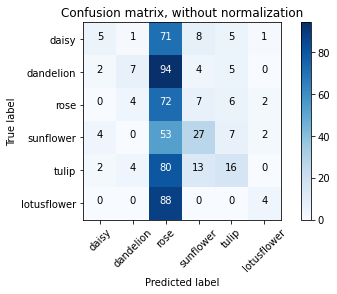

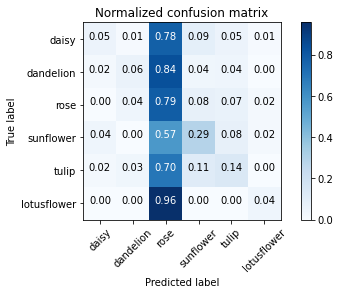

In [ ]:
#Naive Bayes
Experiment(X_features, label, GaussianNB(), classes)

              precision    recall  f1-score   support

       daisy       0.26      0.30      0.28        91
   dandelion       0.36      0.36      0.36       112
        rose       0.19      0.22      0.21        91
   sunflower       0.27      0.25      0.26        93
       tulip       0.33      0.25      0.29       115
 lotusflower       0.40      0.43      0.42        92

    accuracy                           0.30       594
   macro avg       0.30      0.30      0.30       594
weighted avg       0.30      0.30      0.30       594

[[27 16 11  9 13 15]
 [17 40 17 14 10 14]
 [12 15 20 15 19 10]
 [13 16 16 23 13 12]
 [15 19 23 20 29  9]
 [21  5 17  5  4 40]]
0.30134680134680136


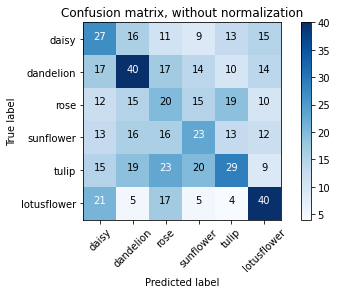

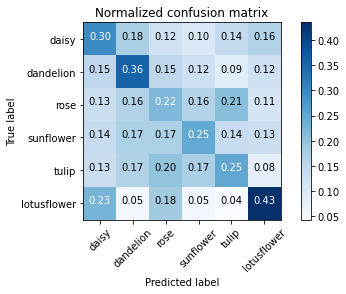

In [ ]:
#Decision Tree
Experiment(X_features, label, DecisionTreeClassifier(), classes)

              precision    recall  f1-score   support

       daisy       0.44      0.42      0.43        91
   dandelion       0.69      0.50      0.58       112
        rose       0.32      0.40      0.36        91
   sunflower       0.44      0.54      0.49        93
       tulip       0.44      0.23      0.30       115
 lotusflower       0.45      0.71      0.55        92

    accuracy                           0.46       594
   macro avg       0.47      0.46      0.45       594
weighted avg       0.47      0.46      0.45       594

[[38  5 11 11  6 20]
 [13 56 14 11  9  9]
 [ 4  7 36 17  8 19]
 [13  4  9 50  8  9]
 [10  6 31 20 26 22]
 [ 8  3 10  4  2 65]]
0.4562289562289562


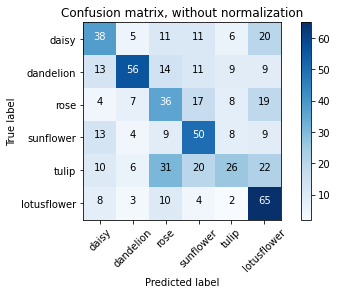

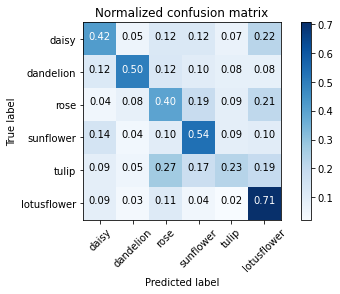

In [ ]:
#Random Forest
Experiment(X_features, label, RandomForestClassifier(), classes)

              precision    recall  f1-score   support

       daisy       0.40      0.42      0.41        91
   dandelion       0.56      0.42      0.48       112
        rose       0.28      0.34      0.31        91
   sunflower       0.42      0.46      0.44        93
       tulip       0.46      0.28      0.35       115
 lotusflower       0.48      0.70      0.57        92

    accuracy                           0.43       594
   macro avg       0.43      0.44      0.43       594
weighted avg       0.44      0.43      0.42       594

[[38  7 14 13  3 16]
 [22 47 11 12  9 11]
 [ 9  8 31 17 11 15]
 [13  7 12 43  9  9]
 [ 7 10 34 15 32 17]
 [ 5  5 10  3  5 64]]
0.4292929292929293


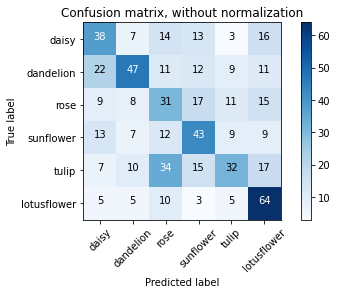

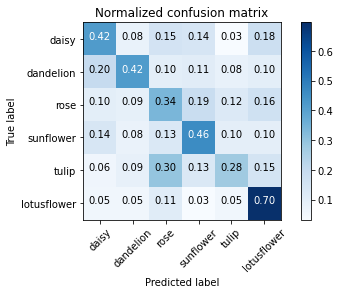

In [ ]:
#KNeighborsClassifier
Experiment(X_features, label, KNeighborsClassifier(), classes)

              precision    recall  f1-score   support

       daisy       0.29      0.44      0.35        91
   dandelion       0.87      0.29      0.44       112
        rose       0.26      0.77      0.38        91
   sunflower       0.50      0.56      0.53        93
       tulip       0.26      0.04      0.07       115
 lotusflower       0.57      0.14      0.23        92

    accuracy                           0.36       594
   macro avg       0.46      0.37      0.33       594
weighted avg       0.46      0.36      0.33       594

[[40  3 30 13  2  3]
 [28 33 36 10  5  0]
 [ 8  1 70  7  2  3]
 [12  0 25 52  3  1]
 [23  1 70 13  5  3]
 [25  0 43  9  2 13]]
0.35858585858585856


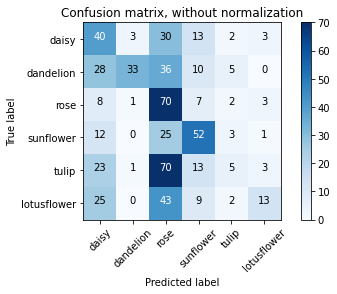

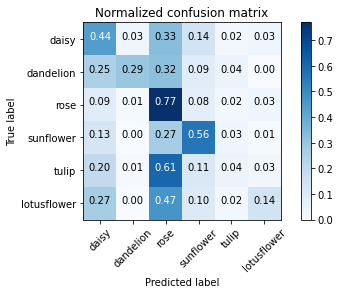

In [ ]:
#SGDClassifier
Experiment(X_features, label, SGDClassifier(), classes)